# Arima Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima import auto_arima 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
sns.set()
# https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city#

In [2]:
data = pd.read_csv("assets/Tetuan_City_power_consumption.csv") 
data.columns = data.columns.str.replace(' ','_')
data.DateTime = pd.to_datetime(data.DateTime)
data.set_index('DateTime', inplace=True)
# Zone 1
data_zone1 = data[['Zone_1_Power_Consumption']]

# Changing frequency to daily
data_zone1 = data_zone1.resample('D').sum()

### Checking for seanality

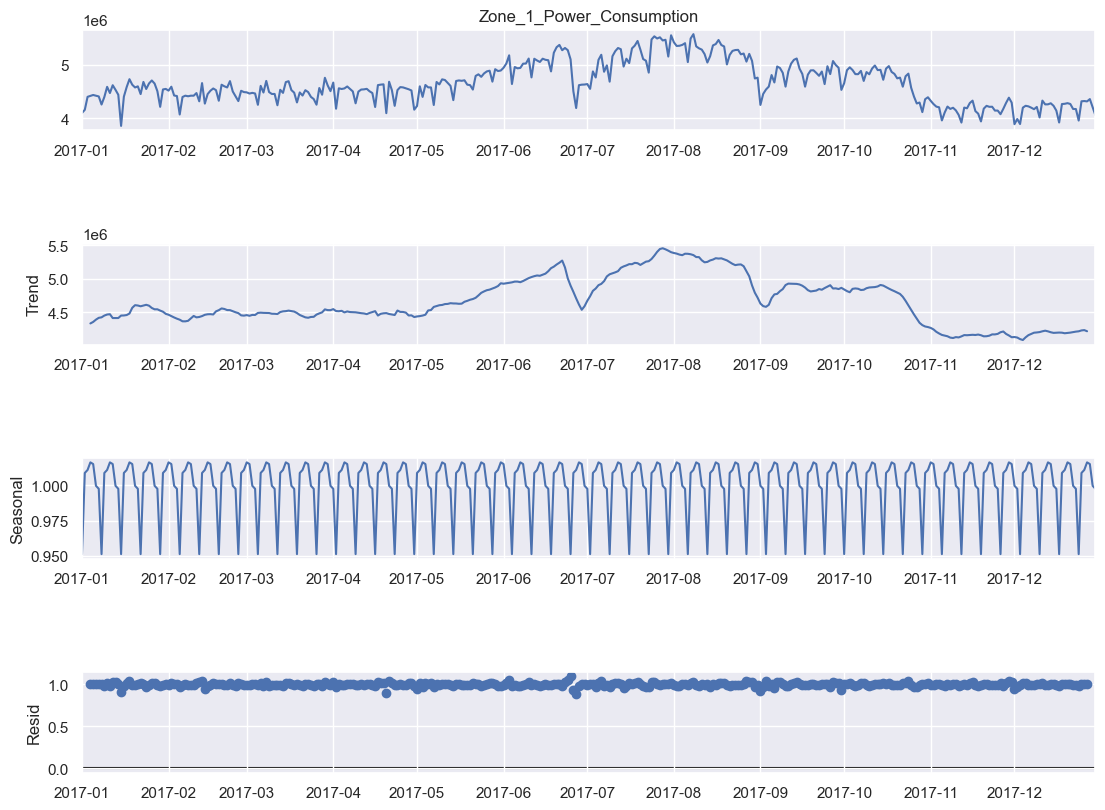

In [3]:
# Specify multiplicative model  
fig = seasonal_decompose(data_zone1['Zone_1_Power_Consumption'],model='mul').plot();
fig.set_size_inches((12, 9))
plt.show()

In [4]:
# Defining parameters

df_ = data_zone1[['Zone_1_Power_Consumption']]
test_size = 0.15
column = 'Zone_1_Power_Consumption'
seasonal_status =True
seasonal_period = 7

In [5]:
#Spliting data to train and test

train_test_cutoff = int(len(df_)*(1-test_size))
train = df_.iloc[:train_test_cutoff] # Drop the last 27 years of our data
test = df_.iloc[train_test_cutoff:]

In [6]:
# Finding best model parameters

best_fit = auto_arima(df_[[column]],trace=True ,
                      information_criterion='aic',
                      seasonal=seasonal_status,
                      D=1,
                      m=seasonal_period, 
                      error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=9659.326, Time=1.69 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=9804.872, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=9707.475, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=9718.490, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=9802.978, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[7] intercept   : AIC=9670.806, Time=1.12 sec
 ARIMA(2,0,2)(1,1,0)[7] intercept   : AIC=9702.911, Time=1.05 sec
 ARIMA(2,0,2)(2,1,1)[7] intercept   : AIC=9659.565, Time=2.71 sec
 ARIMA(2,0,2)(1,1,2)[7] intercept   : AIC=9655.163, Time=2.63 sec
 ARIMA(2,0,2)(0,1,2)[7] intercept   : AIC=9661.147, Time=2.53 sec
 ARIMA(2,0,2)(2,1,2)[7] intercept   : AIC=inf, Time=3.15 sec
 ARIMA(1,0,2)(1,1,2)[7] intercept   : AIC=9652.265, Time=1.64 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept   : AIC=9651.870, Time=1.20 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=9669.258, Time=0.65 sec
 ARIMA(1,0,2)(1,1,1)[7] intercept   : 

In [7]:
# Assigning the best_fit model parameters to variables

order_ = best_fit.order
seasonal_order_ = best_fit.seasonal_order

In [8]:
# Deciding whether use Sarima or arima model based on "seasonal_status" input

if seasonal_status:  
        model = SARIMAX(train[column].astype(float), 
                        order= order_, 
                        seasonal_order= seasonal_order_).fit()
        print("SARIMAX model")
else:
        model = ARIMA(train[column].astype(float), order=order_).fit()
        print("ARIMA model")

SARIMAX model


C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
# Predicting 

# We want to start our predictions at the end of our training data 
start = len(train)

# We want to predict our entire DF - 1 because the end is inclusive. 
end = len(train) + len(test) - 1

predictions = model.predict(start=start, end=end, typ='levels').rename(f'best_fit{order_}')

# Plotting our predictions for Test period:  Nov-06 to Dec-30

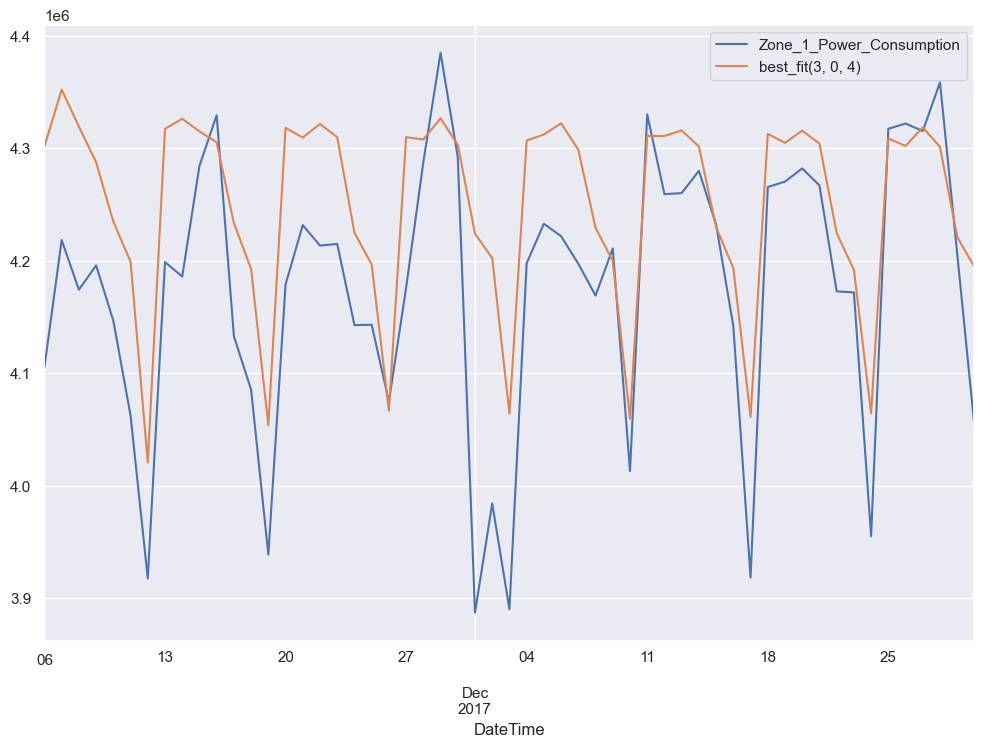

In [10]:
test[column].plot(figsize=(12,8), legend=True)
predictions.plot(legend=True);
plt.show()

# Model Evaluation 

In [11]:
print(f'rmse: {rmse(test[column],predictions)}')
# We can also compare the mean values for our predictions and mean values for the test set to see how we 
# are doing

print(f'Test Mean: {test[column].mean()}')
print(f'Prediction Mean: {predictions.mean()}')

if seasonal_status:  # It is deciding whether use Sarimax or arima model based on "seasonal_status" input

    full_data_model =SARIMAX(df_[column].astype(float), 
                                                order=order_, 
                                                seasonal_order=seasonal_order_).fit()
else:

    full_data_model = ARIMA(df_[column].astype(float), order=order_,).fit()



rmse: 102710.69025931486
Test Mean: 4176410.2081952724
Prediction Mean: 4250196.514150128


C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Saving model as model_arima.plk

In [13]:
# # save model
# full_data_model.save("models/model_arima.pkl")

In [14]:
loaded_model = ARIMAResults.load('models/model_arima.pkl')

# Forecast

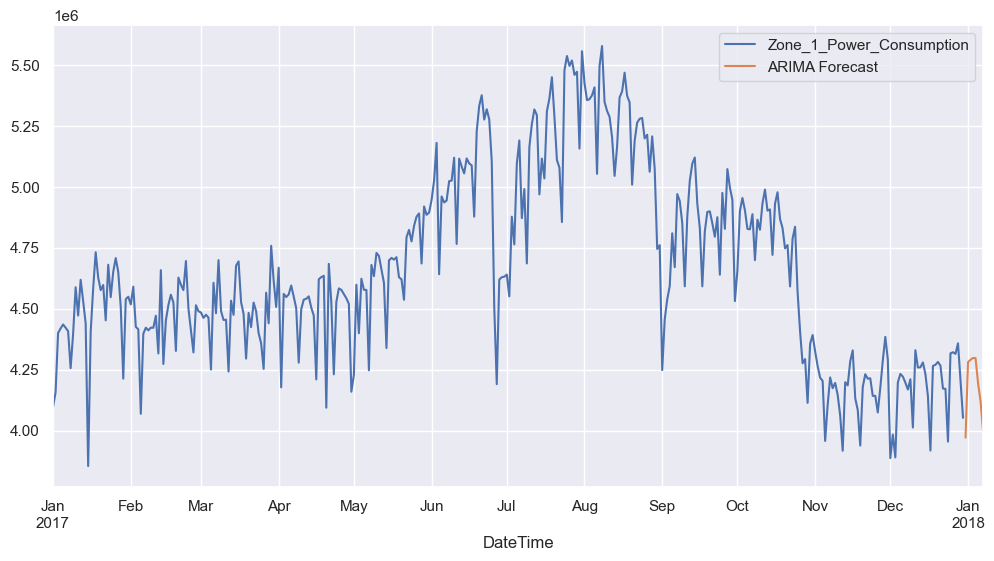

In [16]:
forecast = loaded_model.predict(start=len(df_), end=len(df_)+7, typ='levels').rename('ARIMA Forecast')

df_[column].plot(legend=True,figsize=(12,6))
forecast.plot(legend=True);